In [ ]:
from utilities import load_rmqs_data
from plot_distribution import plot_land_use_distribution
data = load_rmqs_data()

Reading C:\Users\aburg\Documents\analyses\rmqs_exploration\results\full_dataset.csv


In [2]:
data['relative_otu_richness']

id_site
6        1.194805
7        1.112662
8             NaN
9        1.281393
10       1.105395
           ...   
11438         NaN
11441         NaN
11797         NaN
11923         NaN
12258         NaN
Name: relative_otu_richness, Length: 2123, dtype: float64

Relabelling 458 values from ['Continental_Fluvisol', 'Continental_Leptosol', 'Atlantic_Others', 'Alpine_Cambisol', 'Continental_Albeluvisol', 'Continental_Podzol', 'Alpine_Leptosol', 'Continental_Others', 'Mediterranean_Fluvisol', 'Mediterranean_Luvisol', 'Alpine_Podzol', 'Mediterranean_Others', 'Atlantic_nan', 'Alpine_Luvisol', 'Alpine_Fluvisol', 'Mediterranean_Podzol', 'Mediterranean_nan', 'Alpine_Others', 'Continental_nan'] to Others in context.


c:\Users\aburg\Documents\analyses\rmqs_exploration\virtual_env\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Saved figure to: C:\Users\aburg\Documents\analyses\rmqs_exploration\results\distribution\distribution_relative_otu_richness_by_context_context.png


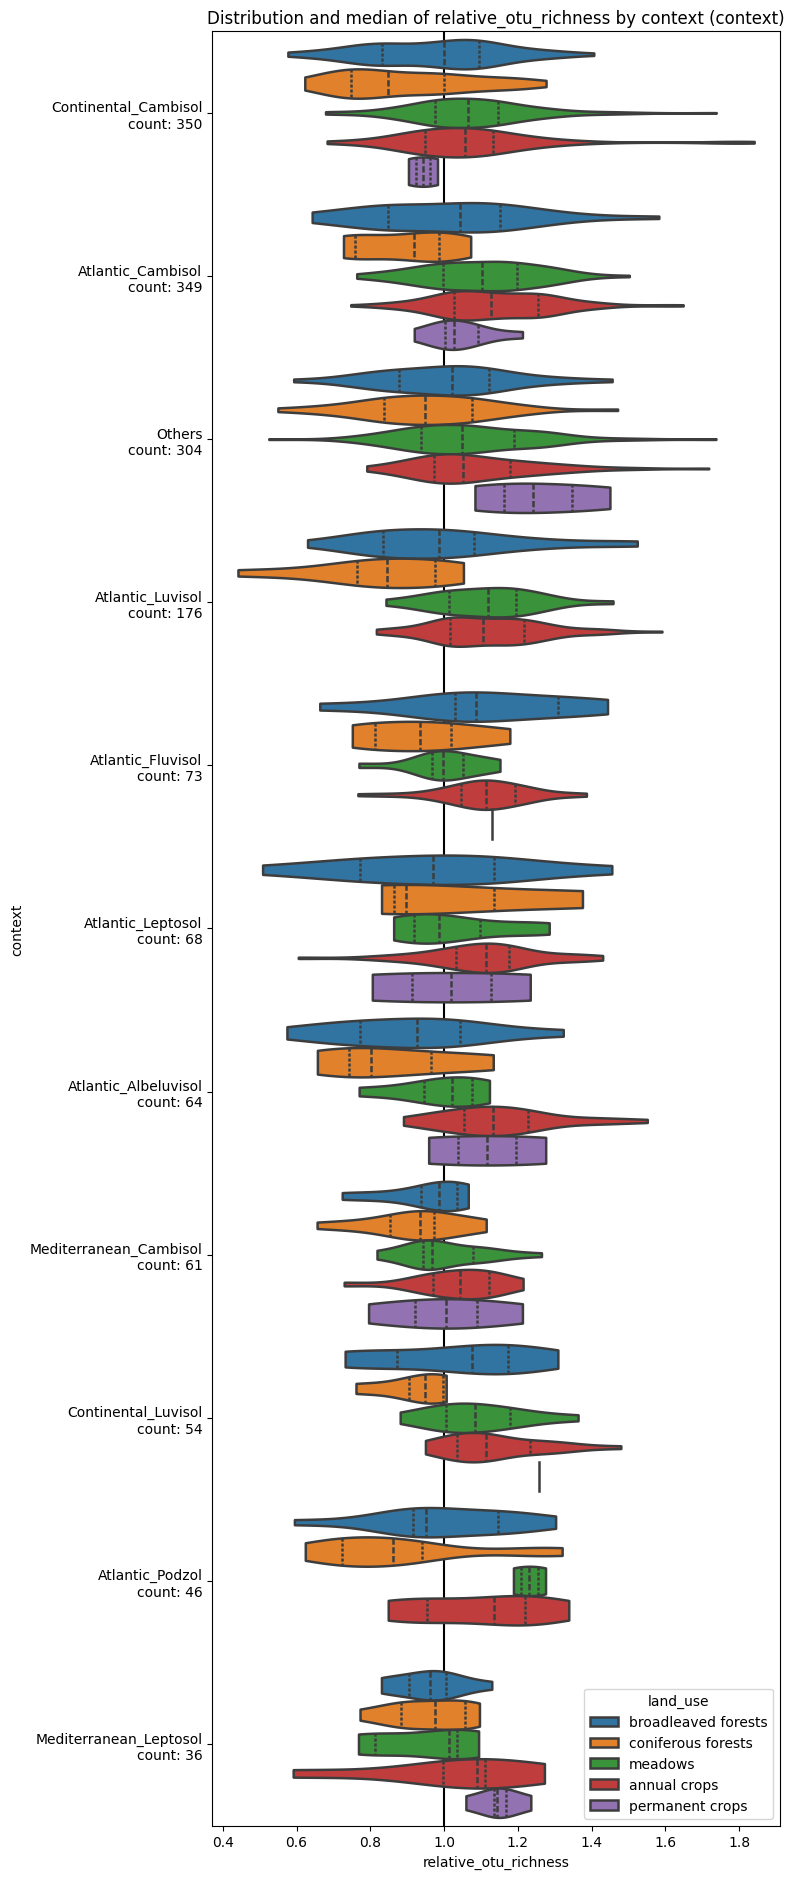

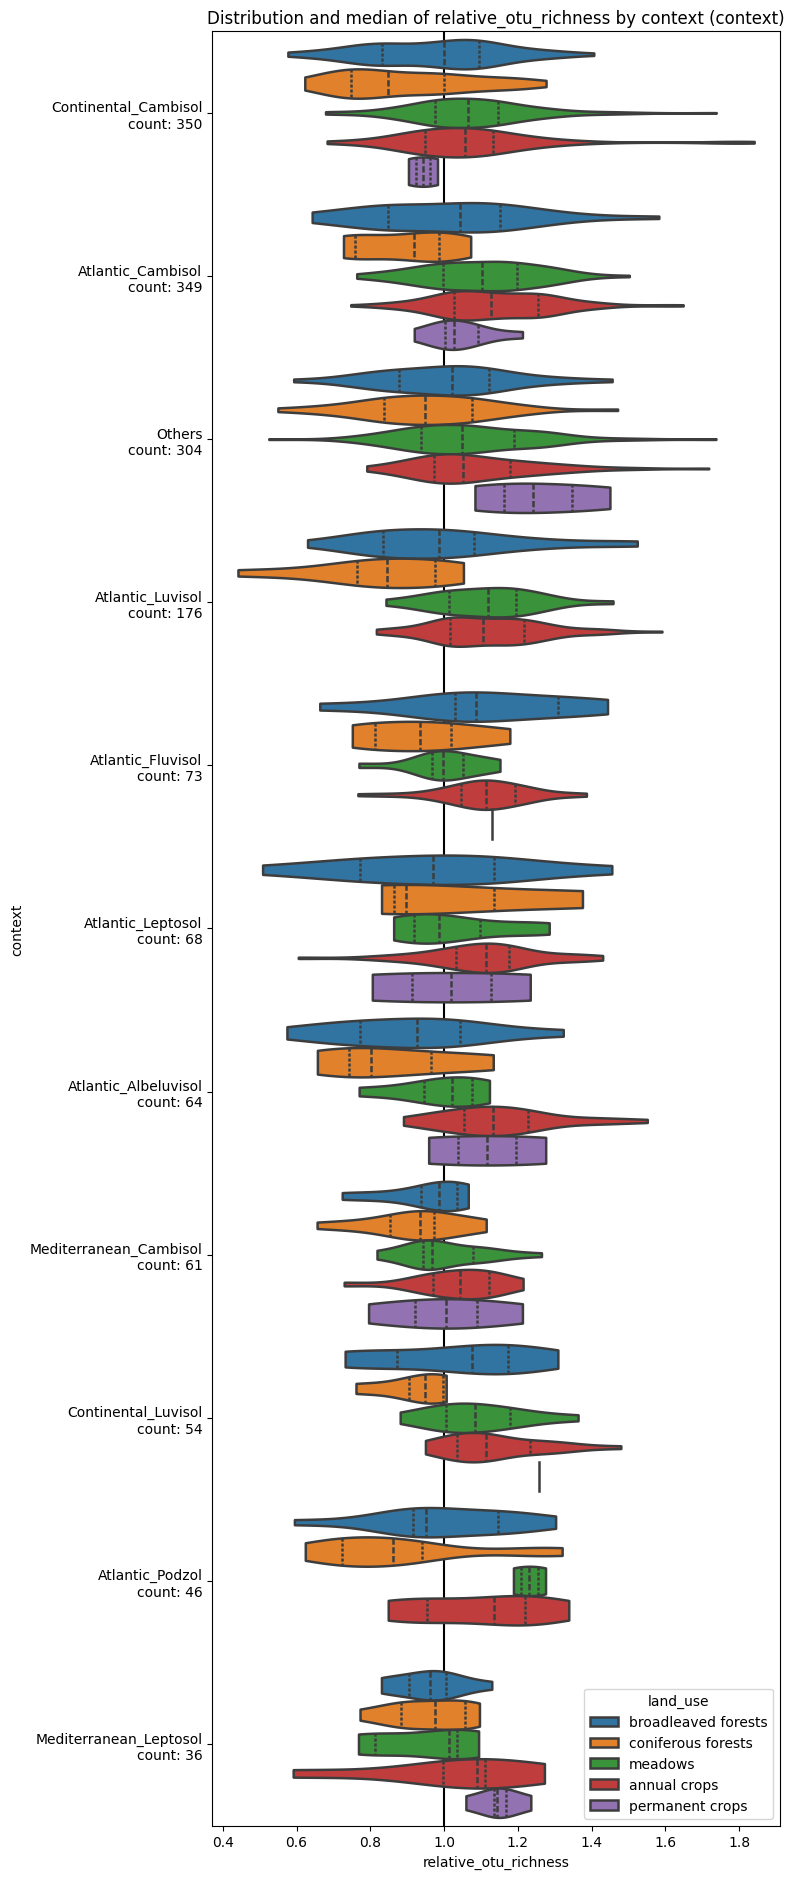

In [3]:
plot_land_use_distribution(data, "relative_otu_richness", "context", relabel_approach="top_cats", relabel_param=10)